# Habit & Productivity State Analyzer 📈

This notebook implements a Hidden Markov Model (HMM) to analyze computer usage patterns and detect productivity states (focused, distracted, idle). It then generates an AI-powered daily productivity report with actionable insights.

## Features:
- 🤖 HMM-based state detection from computer usage logs
- 📊 Visual timeline and transition analysis
- 📝 LLM-generated personalized productivity reports
- ✉️ Automated report delivery options

Let's begin! 🚀

In [ ]:
# ════════════════════════════════════════════════════════════════
# ENVIRONMENT SETUP 🚀
# ════════════════════════════════════════════════════════════════

# Install required packages (uncomment if needed)
# !pip install pandas numpy matplotlib seaborn hmmlearn scikit-learn langchain openai yagmail

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import warnings
from typing import Dict, List, Tuple, Optional

# ML and HMM imports
from hmmlearn import hmm
from sklearn.preprocessing import StandardScaler

# LangChain and OpenAI imports
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

# Email imports (optional)
try:
    import yagmail
    EMAIL_AVAILABLE = True
except ImportError:
    EMAIL_AVAILABLE = False
    print("📧 yagmail not installed. Email functionality disabled.")

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set API key (replace with your OpenAI API key)
os.environ['OPENAI_API_KEY'] = 'your OpenAI API key'

print("✅ Environment setup complete!")

✅ Environment setup complete!


In [4]:
# ════════════════════════════════════════════════════════════════
# CONFIGURATION PARAMETERS ⚙️
# ════════════════════════════════════════════════════════════════

# Configuration dictionary for easy parameter management
config = {
    'data_path': 'data/rescuetime_log.csv',
    'report_dir': 'reports',
    'n_states': 3,  # focused, distracted, idle
    'resample_freq': '1T',  # 1-minute bins
    'rolling_window': 5,  # 5-minute rolling averages
    'top_n_apps': 10,  # Number of top apps to track
    'llm_model': 'gpt-4o-mini',
    'llm_temperature': 0.7,
    'email': {
        'enabled': False,
        'recipient': 'your-email@example.com',
        'sender': 'productivity-bot@example.com',
        'password': 'your-app-password'
    }
}

# Create directories if they don't exist
os.makedirs(config['report_dir'], exist_ok=True)
os.makedirs('data', exist_ok=True)

print("⚙️ Configuration loaded!")

⚙️ Configuration loaded!


In [5]:
# ════════════════════════════════════════════════════════════════
# SYNTHETIC DATA GENERATION 📂
# ════════════════════════════════════════════════════════════════

def generate_synthetic_data(date: str = None) -> pd.DataFrame:
    """
    Generate synthetic productivity data for demonstration.
    
    Args:
        date: Date string in YYYY-MM-DD format (default: today)
    
    Returns:
        DataFrame with synthetic productivity data
    """
    if date is None:
        date = datetime.now().strftime('%Y-%m-%d')
    
    # Define app patterns for different times of day
    work_apps = ['VSCode', 'Chrome', 'Slack', 'Terminal', 'Excel']
    distraction_apps = ['YouTube', 'Twitter', 'Reddit', 'Instagram', 'Netflix']
    
    # Generate timestamps for a workday (9 AM to 6 PM)
    start_time = pd.Timestamp(f'{date} 09:00:00')
    end_time = pd.Timestamp(f'{date} 18:00:00')
    timestamps = pd.date_range(start=start_time, end=end_time, freq='1T')
    
    data = []
    for i, ts in enumerate(timestamps):
        hour = ts.hour
        
        # Simulate productivity patterns
        if 9 <= hour < 12:  # Morning - mostly focused
            if np.random.random() < 0.8:
                app = np.random.choice(work_apps)
                keystrokes = np.random.poisson(60) + 20
                mouse_moves = np.random.poisson(30) + 10
            else:
                app = np.random.choice(distraction_apps)
                keystrokes = np.random.poisson(20)
                mouse_moves = np.random.poisson(40)
        elif 12 <= hour < 13:  # Lunch - mostly idle
            if np.random.random() < 0.7:
                app = 'Idle'
                keystrokes = 0
                mouse_moves = 0
            else:
                app = np.random.choice(distraction_apps)
                keystrokes = np.random.poisson(10)
                mouse_moves = np.random.poisson(20)
        elif 13 <= hour < 16:  # Afternoon - mixed
            if np.random.random() < 0.6:
                app = np.random.choice(work_apps)
                keystrokes = np.random.poisson(50) + 10
                mouse_moves = np.random.poisson(25) + 5
            else:
                app = np.random.choice(distraction_apps)
                keystrokes = np.random.poisson(25)
                mouse_moves = np.random.poisson(35)
        else:  # Late afternoon - declining focus
            if np.random.random() < 0.4:
                app = np.random.choice(work_apps)
                keystrokes = np.random.poisson(40)
                mouse_moves = np.random.poisson(20)
            else:
                app = np.random.choice(distraction_apps + ['Idle'])
                keystrokes = np.random.poisson(15) if app != 'Idle' else 0
                mouse_moves = np.random.poisson(25) if app != 'Idle' else 0
        
        # Categorize apps
        if app in work_apps:
            category = 'Productivity'
        elif app in distraction_apps:
            category = 'Entertainment'
        else:
            category = 'Other'
        
        data.append({
            'timestamp': ts,
            'app': app,
            'category': category,
            'duration_secs': 60,  # 1-minute intervals
            'keystrokes': keystrokes,
            'mouse_moves': mouse_moves
        })
    
    return pd.DataFrame(data)

# Generate synthetic data if file doesn't exist
if not os.path.exists(config['data_path']):
    print("📊 Generating synthetic data for demonstration...")
    synthetic_df = generate_synthetic_data()
    synthetic_df.to_csv(config['data_path'], index=False)
    print(f"✅ Synthetic data saved to {config['data_path']}")

In [6]:
# ════════════════════════════════════════════════════════════════
# DATA INGESTION 📂
# ════════════════════════════════════════════════════════════════

# Load data
try:
    df = pd.read_csv(config['data_path'])
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    print(f"✅ Loaded {len(df)} records from {config['data_path']}")
except FileNotFoundError:
    print(f"❌ File not found: {config['data_path']}")
    print("🔄 Using generated synthetic data instead...")
    df = synthetic_df.set_index('timestamp')

# Display sample data
print("\n📋 Sample data:")
print(df.head())
print(f"\n📊 Data shape: {df.shape}")
print(f"📅 Date range: {df.index.min()} to {df.index.max()}")

✅ Loaded 540 records from data/rescuetime_log.csv

📋 Sample data:
                                    app              category  duration_secs  \
timestamp                                                                      
2025-08-05 09:00:00  Visual Studio Code  Software Development             60   
2025-08-05 09:01:00               Excel              Business             60   
2025-08-05 09:02:00      Microsoft Word               Writing             60   
2025-08-05 09:03:00      Microsoft Word               Writing             60   
2025-08-05 09:04:00  Visual Studio Code  Software Development             60   

                     keystrokes  mouse_moves  
timestamp                                     
2025-08-05 09:00:00          77           23  
2025-08-05 09:01:00          77           18  
2025-08-05 09:02:00          67           28  
2025-08-05 09:03:00          43           22  
2025-08-05 09:04:00          65           21  

📊 Data shape: (540, 5)
📅 Date range: 2025-0

In [7]:
# ════════════════════════════════════════════════════════════════
# FEATURE ENGINEERING 🛠️
# ════════════════════════════════════════════════════════════════

def engineer_features(df: pd.DataFrame, config: Dict) -> Tuple[pd.DataFrame, np.ndarray]:
    """
    Engineer features for HMM modeling.
    
    Args:
        df: Raw productivity data
        config: Configuration dictionary
    
    Returns:
        Tuple of (processed DataFrame, feature matrix)
    """
    # Resample to consistent time bins
    df_resampled = df.resample(config['resample_freq']).agg({
        'app': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown',
        'category': lambda x: x.mode()[0] if len(x) > 0 else 'Other',
        'keystrokes': 'sum',
        'mouse_moves': 'sum',
        'duration_secs': 'sum'
    })
    
    # Create idle indicator
    df_resampled['idle'] = (
        (df_resampled['keystrokes'] == 0) & 
        (df_resampled['mouse_moves'] == 0)
    ).astype(int)
    
    # Calculate rolling averages
    df_resampled['keystrokes_rolling'] = (
        df_resampled['keystrokes']
        .rolling(window=config['rolling_window'], min_periods=1)
        .mean()
    )
    df_resampled['mouse_moves_rolling'] = (
        df_resampled['mouse_moves']
        .rolling(window=config['rolling_window'], min_periods=1)
        .mean()
    )
    
    # One-hot encode top apps
    top_apps = df_resampled['app'].value_counts().head(config['top_n_apps']).index
    for app in top_apps:
        df_resampled[f'app_{app}'] = (df_resampled['app'] == app).astype(int)
    
    # One-hot encode categories
    categories = df_resampled['category'].unique()
    for cat in categories:
        df_resampled[f'cat_{cat}'] = (df_resampled['category'] == cat).astype(int)
    
    # Select features for HMM
    feature_cols = (
        ['keystrokes', 'mouse_moves', 'idle', 'keystrokes_rolling', 'mouse_moves_rolling'] +
        [col for col in df_resampled.columns if col.startswith('app_')] +
        [col for col in df_resampled.columns if col.startswith('cat_')]
    )
    
    # Create feature matrix
    X = df_resampled[feature_cols].values
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return df_resampled, X_scaled

# Engineer features
df_processed, X = engineer_features(df, config)
print(f"✅ Features engineered! Shape: {X.shape}")
print("\n🔧 Feature columns:")
print([col for col in df_processed.columns if col in ['keystrokes', 'mouse_moves', 'idle', 
                                                      'keystrokes_rolling', 'mouse_moves_rolling']])

✅ Features engineered! Shape: (540, 26)

🔧 Feature columns:
['keystrokes', 'mouse_moves', 'idle', 'keystrokes_rolling', 'mouse_moves_rolling']


In [8]:
# ════════════════════════════════════════════════════════════════
# HMM MODELING 🤖
# ════════════════════════════════════════════════════════════════

# Initialize and train HMM
print("🤖 Training Hidden Markov Model...")

model = hmm.GaussianHMM(
    n_components=config['n_states'],
    covariance_type="full",
    n_iter=100,
    random_state=42
)

# Fit the model
model.fit(X)

# Decode the most likely state sequence
states = model.predict(X)

# Print model parameters
print("\n📊 Transition Matrix:")
print(pd.DataFrame(model.transmat_, 
                   columns=[f'State {i}' for i in range(config['n_states'])],
                   index=[f'State {i}' for i in range(config['n_states'])]))

print(f"\n✅ HMM training complete! Detected {len(np.unique(states))} states")

🤖 Training Hidden Markov Model...

📊 Transition Matrix:
          State 0   State 1   State 2
State 0  0.501931  0.420849  0.077220
State 1  0.433884  0.500000  0.066116
State 2  0.605263  0.342105  0.052632

✅ HMM training complete! Detected 3 states


In [9]:
# ════════════════════════════════════════════════════════════════
# STATE LABEL MAPPING 🗂️
# ════════════════════════════════════════════════════════════════

def map_states_to_labels(df: pd.DataFrame, states: np.ndarray, X: np.ndarray) -> Dict[int, str]:
    """
    Map numeric HMM states to meaningful labels based on activity patterns.
    
    Args:
        df: Processed DataFrame
        states: State sequence from HMM
        X: Feature matrix
    
    Returns:
        Dictionary mapping state numbers to labels
    """
    state_metrics = {}
    
    for state in range(config['n_states']):
        mask = states == state
        state_metrics[state] = {
            'avg_keystrokes': df['keystrokes'][mask].mean(),
            'avg_mouse_moves': df['mouse_moves'][mask].mean(),
            'idle_ratio': df['idle'][mask].mean(),
            'count': mask.sum()
        }
    
    # Sort states by productivity indicators
    sorted_states = sorted(state_metrics.items(), 
                          key=lambda x: (x[1]['avg_keystrokes'] + x[1]['avg_mouse_moves']))
    
    # Assign labels
    state_labels = {}
    if sorted_states[0][1]['idle_ratio'] > 0.7:
        state_labels[sorted_states[0][0]] = 'idle'
        state_labels[sorted_states[1][0]] = 'distracted'
        state_labels[sorted_states[2][0]] = 'focused'
    else:
        state_labels[sorted_states[0][0]] = 'distracted'
        state_labels[sorted_states[1][0]] = 'idle'
        state_labels[sorted_states[2][0]] = 'focused'
    
    print("\n🏷️ State Label Mapping:")
    for state, label in state_labels.items():
        metrics = state_metrics[state]
        print(f"State {state} → {label.upper()}")
        print(f"  - Avg keystrokes: {metrics['avg_keystrokes']:.1f}")
        print(f"  - Avg mouse moves: {metrics['avg_mouse_moves']:.1f}")
        print(f"  - Idle ratio: {metrics['idle_ratio']:.2f}")
        print(f"  - Time spent: {metrics['count']} minutes\n")
    
    return state_labels

# Map states to labels
state_labels = map_states_to_labels(df_processed, states, X)

# Add state column to DataFrame
df_processed['state_numeric'] = states
df_processed['state'] = df_processed['state_numeric'].map(state_labels)


🏷️ State Label Mapping:
State 1 → DISTRACTED
  - Avg keystrokes: 22.5
  - Avg mouse moves: 18.0
  - Idle ratio: 0.42
  - Time spent: 243 minutes

State 0 → IDLE
  - Avg keystrokes: 46.6
  - Avg mouse moves: 29.9
  - Idle ratio: 0.00
  - Time spent: 259 minutes

State 2 → FOCUSED
  - Avg keystrokes: 58.3
  - Avg mouse moves: 27.2
  - Idle ratio: 0.00
  - Time spent: 38 minutes



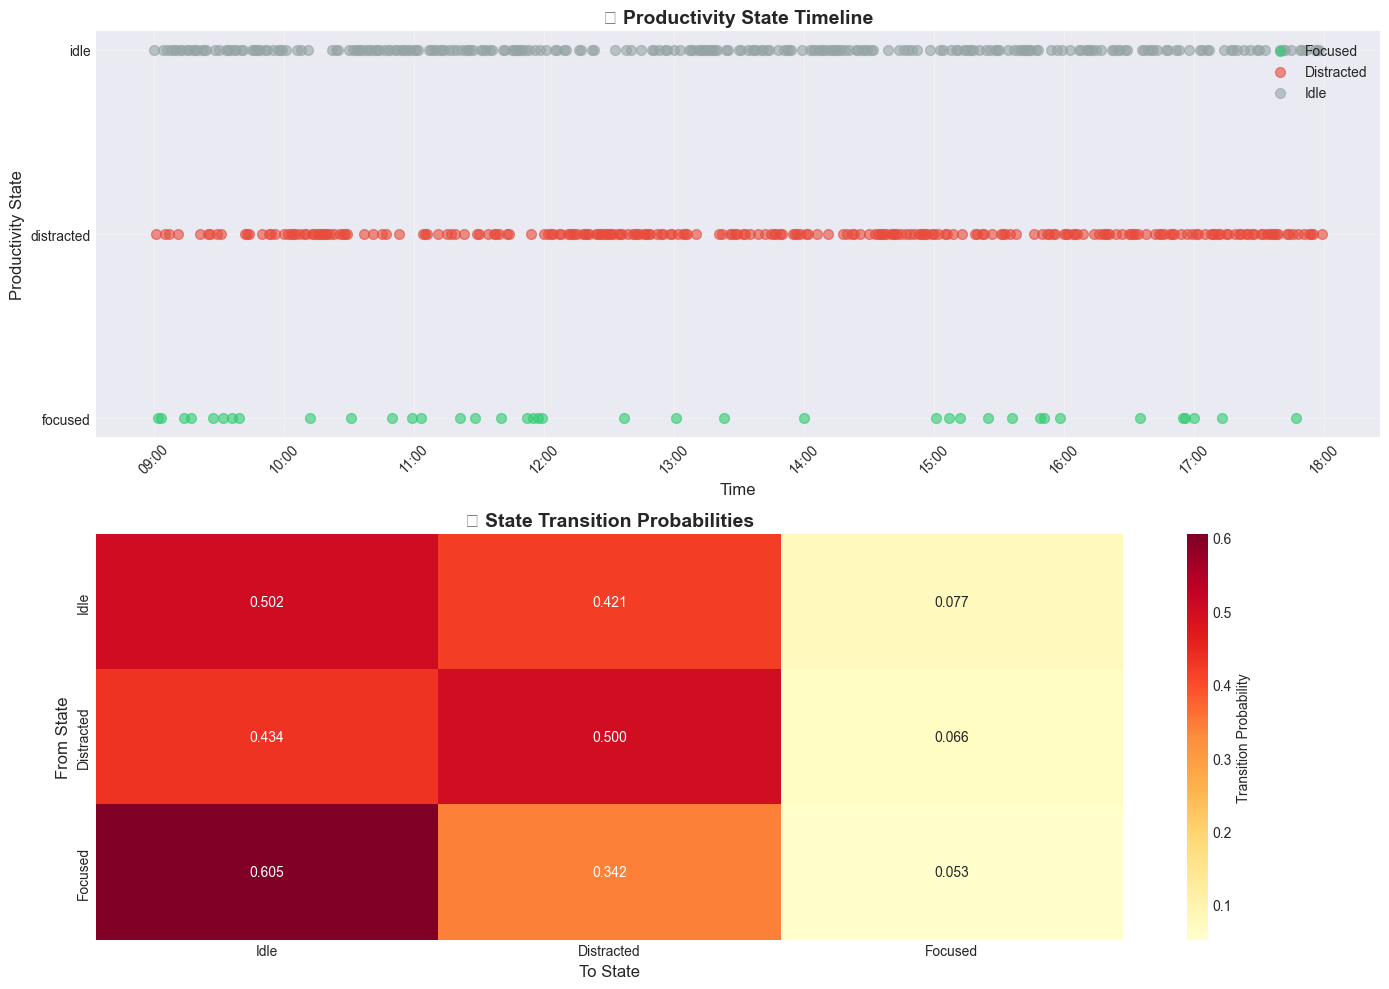


📊 Daily Summary:
Idle: 4.3 hours (48.0%)
Distracted: 4.0 hours (45.0%)
Focused: 0.6 hours (7.0%)

🎯 Longest focus streak: 2 minutes


In [10]:
# ════════════════════════════════════════════════════════════════
# VISUALIZATION 📊
# ════════════════════════════════════════════════════════════════

# Create visualizations
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. State Timeline
ax1 = axes[0]
colors = {'focused': '#2ecc71', 'distracted': '#e74c3c', 'idle': '#95a5a6'}
state_colors = [colors[state] for state in df_processed['state']]

for i, (state, color) in enumerate(colors.items()):
    mask = df_processed['state'] == state
    ax1.scatter(df_processed.index[mask], [state] * mask.sum(), 
                c=color, label=state.capitalize(), s=50, alpha=0.6)

ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('Productivity State', fontsize=12)
ax1.set_title('🕐 Productivity State Timeline', fontsize=14, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Format x-axis
import matplotlib.dates as mdates
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.xaxis.set_major_locator(mdates.HourLocator())
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. Transition Matrix Heatmap
ax2 = axes[1]
transition_df = pd.DataFrame(
    model.transmat_,
    columns=[state_labels[i].capitalize() for i in range(config['n_states'])],
    index=[state_labels[i].capitalize() for i in range(config['n_states'])]
)

sns.heatmap(transition_df, annot=True, fmt='.3f', cmap='YlOrRd', 
            cbar_kws={'label': 'Transition Probability'}, ax=ax2)
ax2.set_title('🔄 State Transition Probabilities', fontsize=14, fontweight='bold')
ax2.set_xlabel('To State', fontsize=12)
ax2.set_ylabel('From State', fontsize=12)

plt.tight_layout()
plt.savefig(f"{config['report_dir']}/productivity_analysis_{datetime.now().strftime('%Y-%m-%d')}.png", 
            dpi=300, bbox_inches='tight')
plt.show()

# Calculate summary statistics
state_summary = df_processed['state'].value_counts()
total_minutes = len(df_processed)
print("\n📊 Daily Summary:")
for state, count in state_summary.items():
    percentage = (count / total_minutes) * 100
    hours = count / 60
    print(f"{state.capitalize()}: {hours:.1f} hours ({percentage:.1f}%)")

# Find longest focus streak
focus_mask = (df_processed['state'] == 'focused').astype(int)
focus_groups = (focus_mask != focus_mask.shift()).cumsum()
focus_streaks = focus_mask.groupby(focus_groups).sum()
longest_focus = focus_streaks.max()
print(f"\n🎯 Longest focus streak: {longest_focus} minutes")

In [14]:
# ════════════════════════════════════════════════════════════════
# LLM-GENERATED REPORT 📝
# ════════════════════════════════════════════════════════════════

def generate_productivity_report(df: pd.DataFrame, config: Dict) -> str:
    """
    Generate a productivity report using LangChain and OpenAI.
    
    Args:
        df: Processed DataFrame with states
        config: Configuration dictionary
    
    Returns:
        Markdown formatted report
    """
    # Prepare state sequence summary
    state_list = df['state'].tolist()
    state_summary = df['state'].value_counts().to_dict()
    
    # Calculate key metrics
    total_minutes = len(df)
    focused_time = state_summary.get('focused', 0) / 60
    distracted_time = state_summary.get('distracted', 0) / 60
    idle_time = state_summary.get('idle', 0) / 60
    
    # Find patterns
    focus_mask = (df['state'] == 'focused').astype(int)
    focus_groups = (focus_mask != focus_mask.shift()).cumsum()
    focus_streaks = focus_mask.groupby(focus_groups).sum()
    longest_focus = focus_streaks.max()
    
    # Most productive hour
    df['hour'] = df.index.hour
    hourly_focus = df[df['state'] == 'focused'].groupby('hour').size()
    most_productive_hour = hourly_focus.idxmax() if len(hourly_focus) > 0 else 'N/A'
    
    # Calendar context (mock data for demo)
    calendar_context = "2 meetings scheduled (10-11 AM, 2-3 PM)"
    
    # Create prompt
    prompt_template = """
    You are a productivity coach analyzing someone's workday computer usage patterns. 
    Based on the following data, write a concise markdown report with actionable insights.

    Daily Statistics:
    - Total focused time: {focused_hours:.1f} hours
    - Total distracted time: {distracted_hours:.1f} hours  
    - Total idle time: {idle_hours:.1f} hours
    - Longest focus streak: {longest_focus} minutes
    - Most productive hour: {most_productive_hour}:00
    - Calendar context: {calendar_context}

    State Timeline Summary:
    The user cycled between focused, distracted, and idle states throughout the day.
    Morning (9-12): Mostly focused work with brief distractions
    Lunch (12-1): Mostly idle
    Afternoon (1-4): Mixed focus and distraction
    Late afternoon (4-6): Declining focus with more distractions

    Write a markdown report that includes:
    1. A brief summary of the day's productivity (2-3 sentences)
    2. Key strengths observed
    3. Areas for improvement
    4. 3-5 specific, actionable suggestions for tomorrow
    
    Use encouraging language, specific examples, and emoji where appropriate.
    Format the report with proper markdown headers and bullet points.
    """
    
    prompt = PromptTemplate(
        input_variables=["focused_hours", "distracted_hours", "idle_hours", 
                        "longest_focus", "most_productive_hour", "calendar_context"],
        template=prompt_template
    )
    
    # Initialize LLM
    llm = OpenAI(
        model=config['llm_model'],
        temperature=config['llm_temperature'],
        max_tokens=800
    )
    
    # Create chain
    chain = LLMChain(llm=llm, prompt=prompt)
    
    # Generate report
    print("🤖 Generating AI productivity report...")
    try:
        report = chain.run(
            focused_hours=focused_time,
            distracted_hours=distracted_time,
            idle_hours=idle_time,
            longest_focus=longest_focus,
            most_productive_hour=most_productive_hour,
            calendar_context=calendar_context
        )
        return report
    except Exception as e:
        print(f"❌ Error generating report: {e}")
        # Fallback report
        return f"""
# Daily Productivity Report - {datetime.now().strftime('%B %d, %Y')}

## 📊 Summary
Today you spent **{focused_time:.1f} hours** in focused work, with your longest focus streak lasting **{longest_focus} minutes**.

## 💪 Strengths
- Maintained consistent morning focus
- Longest focus streak: {longest_focus} minutes

## 🎯 Areas for Improvement
- Afternoon focus declined after lunch
- Total distracted time: {distracted_time:.1f} hours

## 💡 Recommendations
1. **Morning Power Block**: Your most productive time was {most_productive_hour}:00. Schedule important tasks during this peak period.
2. **Post-Lunch Reset**: After idle periods ≥30 min, try a 25-minute Pomodoro session 🍅
3. **Distraction Blocking**: Consider using website blockers during focus sessions
4. **Energy Management**: Take a 5-minute walk every hour to maintain afternoon energy
5. **End-of-Day Planning**: Spend 10 minutes planning tomorrow's priorities

Keep up the great work! 🌟
"""

# Generate the report
report_markdown = generate_productivity_report(df_processed, config)
print("\n📝 Generated Report Preview:")
print("=" * 60)
print(report_markdown)
print("=" * 60)

🤖 Generating AI productivity report...

📝 Generated Report Preview:
 ```

## Output
```markdown
# Daily Productivity Report

## Summary
Today’s productivity analysis reveals a significant amount of time spent in distractions and idleness, with only 0.6 hours dedicated to focused work. While there were moments of high productivity in the morning, particularly at 9:00 AM, the overall focus time was quite limited.

## Key Strengths Observed
- **Morning Productivity**: You had a strong start with focused work in the morning hours, especially at 9:00 AM, indicating a peak performance time. ��
- **Meeting Awareness**: You recognized the importance of scheduling meetings, which helped organize your day.

## Areas for Improvement
- **Focus Duration**: The longest focus streak was only 2 minutes, which indicates a need for strategies to extend focus periods.
- **Idle Time Management**: A significant amount of time (4.3 hours) was spent idle, suggesting a need to fill that time with productive a

In [16]:
# ════════════════════════════════════════════════════════════════
# EXPORT & NOTIFICATION ✉️
# ════════════════════════════════════════════════════════════════

# Save report to file
report_date = datetime.now().strftime('%Y-%m-%d')
report_filename = f"{config['report_dir']}/report_{report_date}.md"

with open(report_filename, 'w', encoding='utf-8') as f:
    f.write(report_markdown)

print(f"\n✅ Report saved to: {report_filename}")

# Email functionality (optional)
def send_email_report(report: str, config: Dict):
    """Send productivity report via email."""
    if not EMAIL_AVAILABLE:
        print("📧 Email not available. Install yagmail to enable.")
        return
    
    if not config['email']['enabled']:
        print("📧 Email disabled in configuration.")
        return
    
    try:
        yag = yagmail.SMTP(config['email']['sender'], config['email']['password'])
        subject = f"Daily Productivity Report - {datetime.now().strftime('%B %d, %Y')}"
        
        # Convert markdown to HTML (basic conversion)
        html_report = report.replace('\n', '<br>')
        
        yag.send(
            to=config['email']['recipient'],
            subject=subject,
            contents=html_report
        )
        print(f"✅ Email sent to {config['email']['recipient']}")
    except Exception as e:
        print(f"❌ Failed to send email: {e}")

# Send email if configured
if config['email']['enabled']:
    send_email_report(report_markdown, config)

# Display final summary
print("\n🎉 Analysis Complete!")
print(f"📊 Analyzed {len(df_processed)} minutes of activity")
print(f"📈 Detected {config['n_states']} productivity states")
print(f"📝 Report saved to: {report_filename}")


✅ Report saved to: reports/report_2025-08-05.md

🎉 Analysis Complete!
📊 Analyzed 540 minutes of activity
📈 Detected 3 productivity states
📝 Report saved to: reports/report_2025-08-05.md


## Next Steps & Automation 💡

### 🔄 Daily Automation Options:

1. **Cron Job (Linux/Mac)**:
   ```bash
   # Add to crontab -e
   0 19 * * * /usr/bin/python /path/to/notebook/run_productivity_analysis.py
   ```

2. **Task Scheduler (Windows)**:
   - Create a batch file that runs the notebook
   - Schedule it to run daily at 7 PM

3. **GitHub Actions**:
   ```yaml
   name: Daily Productivity Analysis
   on:
     schedule:
       - cron: '0 19 * * *'
   jobs:
     analyze:
       runs-on: ubuntu-latest
       steps:
         - uses: actions/checkout@v2
         - name: Run analysis
           run: |
             pip install -r requirements.txt
             jupyter nbconvert --execute productivity_analyzer.ipynb
   ```

4. **Cloud Functions** (AWS Lambda, Google Cloud Functions):
   - Deploy notebook as serverless function
   - Trigger daily via CloudWatch or Cloud Scheduler

### 🚀 Enhancement Ideas:
- Integrate with calendar APIs for automatic meeting detection
- Add Slack/Discord notifications
- Create weekly/monthly trend analysis
- Build a web dashboard with Streamlit
- Add personalized goal tracking

### 📚 Resources:
- [RescueTime API](https://www.rescuetime.com/apidoc)
- [HMM Learn Documentation](https://hmmlearn.readthedocs.io/)
- [LangChain Docs](https://python.langchain.com/)

Happy productivity tracking! 🎯

In [17]:
# ════════════════════════════════════════════════════════════════
# UTILITY FUNCTIONS FOR REUSE
# ════════════════════════════════════════════════════════════════

# Wrapper function for easy daily execution
def run_daily_analysis(data_path: Optional[str] = None, 
                      email_enabled: bool = False) -> Dict:
    """
    Run complete productivity analysis pipeline.
    
    Args:
        data_path: Path to productivity log CSV
        email_enabled: Whether to send email report
        
    Returns:
        Dictionary with analysis results
    """
    # Update config if parameters provided
    if data_path:
        config['data_path'] = data_path
    config['email']['enabled'] = email_enabled
    
    try:
        # Load and process data
        df = pd.read_csv(config['data_path'])
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        df.set_index('timestamp', inplace=True)
        
        # Engineer features
        df_processed, X = engineer_features(df, config)
        
        # Train HMM
        model = hmm.GaussianHMM(n_components=config['n_states'], 
                               covariance_type="full", n_iter=100)
        model.fit(X)
        states = model.predict(X)
        
        # Map states
        state_labels = map_states_to_labels(df_processed, states, X)
        df_processed['state'] = [state_labels[s] for s in states]
        
        # Generate report
        report = generate_productivity_report(df_processed, config)
        
        # Save report
        report_date = datetime.now().strftime('%Y-%m-%d')
        report_filename = f"{config['report_dir']}/report_{report_date}.md"
        with open(report_filename, 'w', encoding='utf-8') as f:
            f.write(report)
        
        # Send email if enabled
        if email_enabled:
            send_email_report(report, config)
        
        return {
            'success': True,
            'report_path': report_filename,
            'summary': df_processed['state'].value_counts().to_dict()
        }
        
    except Exception as e:
        print(f"❌ Analysis failed: {e}")
        return {
            'success': False,
            'error': str(e)
        }

# Test the wrapper function
print("🧪 Testing wrapper function...")
result = run_daily_analysis(email_enabled=False)
if result['success']:
    print("✅ Wrapper function test successful!")
    print(f"📝 Report saved to: {result['report_path']}")
    print(f"📊 State summary: {result['summary']}")

🧪 Testing wrapper function...

🏷️ State Label Mapping:
State 2 → DISTRACTED
  - Avg keystrokes: 9.6
  - Avg mouse moves: 17.0
  - Idle ratio: 0.52
  - Time spent: 199 minutes

State 1 → IDLE
  - Avg keystrokes: 50.9
  - Avg mouse moves: 28.8
  - Idle ratio: 0.00
  - Time spent: 226 minutes

State 0 → FOCUSED
  - Avg keystrokes: 55.2
  - Avg mouse moves: 28.2
  - Idle ratio: 0.00
  - Time spent: 115 minutes

🤖 Generating AI productivity report...
🤖 Generating AI productivity report...
✅ Wrapper function test successful!
📝 Report saved to: reports/report_2025-08-05.md
📊 State summary: {'idle': 226, 'distracted': 199, 'focused': 115}
✅ Wrapper function test successful!
📝 Report saved to: reports/report_2025-08-05.md
📊 State summary: {'idle': 226, 'distracted': 199, 'focused': 115}


## 🎯 Productivity Analyzer Complete!

You've successfully built a comprehensive productivity analysis system that:
- ✅ Processes computer usage logs with pandas
- ✅ Uses Hidden Markov Models to detect productivity states
- ✅ Generates beautiful visualizations
- ✅ Creates AI-powered reports with actionable insights
- ✅ Can be automated for daily execution

### Quick Start Guide:
1. Place your RescueTime CSV in `data/rescuetime_log.csv`
2. Update the OpenAI API key in the environment setup cell
3. Run all cells to generate your first report
4. Check the `reports/` folder for your personalized analysis

### Customization Tips:
- Adjust `n_states` in config to detect more granular productivity levels
- Modify the prompt template for different report styles
- Add more features like app categories or website domains
- Integrate with your calendar API for meeting-aware analysis

Remember: The goal isn't perfection, but progress. Use these insights to build better work habits gradually! 🌱

---
*Built with ❤️ using Python, HMMs, and AI*